In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.integrate import quad
import csv

In [2]:
problems = [('7991-12705', 0.113153), ('8132-6101', 0.129403), ('8244-12704', 0.115137)]

In [3]:
def spectrum_gen(flux, ivar):    
    n = len(flux)
    sumflux = np.zeros(4563)

    for i in range(n):
        for j in range(n):
            flux_ = flux[i,j] * ~do_not_use[i,j]
            flux_filtered = sigma_gen_compare(ivar[i,j], flux_)
            sumflux = np.add(sumflux, flux_)
    return sumflux

In [4]:
def sigma_gen_compare(ivar, flux_masked):
    
    # change ivar array to sigma array 
    
    sigma = np.sqrt(np.abs(np.divide(1, ivar, where = ivar != 0)))
#     print(sigma)
    
    is_less_than_3sigma = flux_masked < 3 * sigma # compare the sigma array 
        
    flux_masked_filtered = flux_masked * ~is_less_than_3sigma # multiply the truth value
    
    return flux_masked_filtered

In [5]:
def gaussian(x, amp, mean, sigma, base):
    return (amp * np.exp(-(x-mean)**2 / (2*sigma**2))) + base

In [6]:
def area_finder(x, y):
    dlmd = (x[-1] - x[0])/len(x)
        
    area = (1/2)*(dlmd)*(y[0] + y[-1] + np.sum(2*(y[1:-1])))

    subtract = y[0] * (x[-1] - x[0])

    subtracted_area = area - subtract
    
    return subtracted_area

In [27]:
c = (3*(10**5)) # speed of light in km/s
l_ha = 6563 # H-alpha wavelength

wave_slice difference 28.609804315932706
amp 47.17847502620593
mean 7307.66540446836
sigma 7.071691469071165
base 101.73276723660844
new_amp 148.91124226281437

Flux + continuum = 3708.229321776134
Continuum 2910.5545631576974
Flux = 797.6747586184365


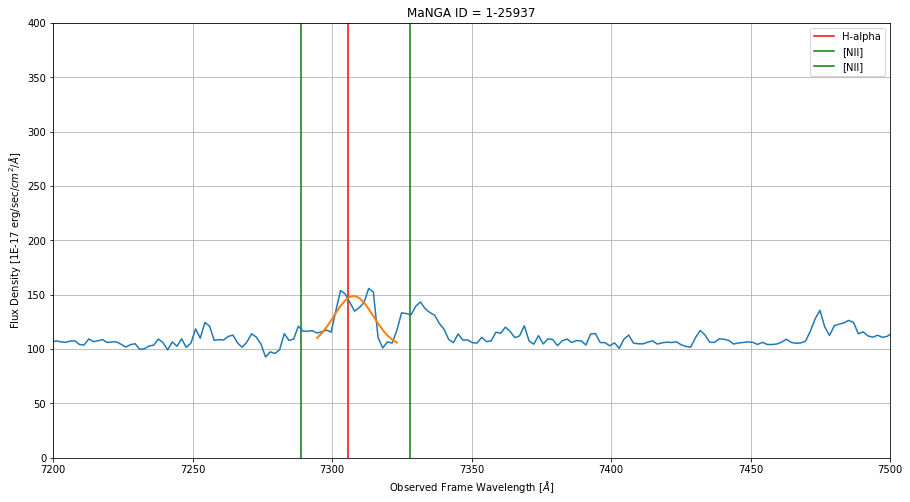

wave_slice difference 29.027851144792294
amp 66.06268101467771
mean 7414.189573474906
sigma 8.630081614617026
base 98.99053939980078
new_amp 165.0532204144785

Flux + continuum = 4163.30171994391
Continuum 2873.482642440114
Flux = 1289.819077503796


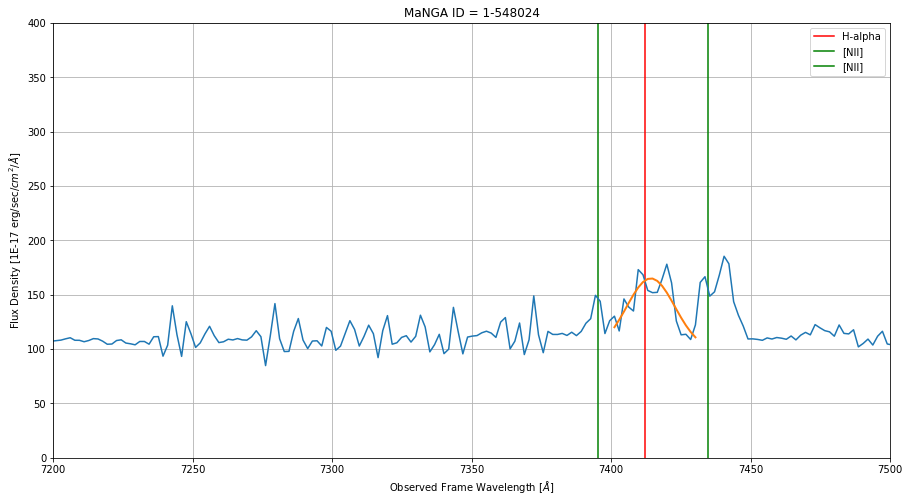

wave_slice difference 28.662554092501523
amp 182.4174775894754
mean 7320.218136869582
sigma 6.661160580848401
base 107.61033613533021
new_amp 290.0278137248056

Flux + continuum = 6007.489808225245
Continuum 3084.3870803911736
Flux = 2923.102727834071


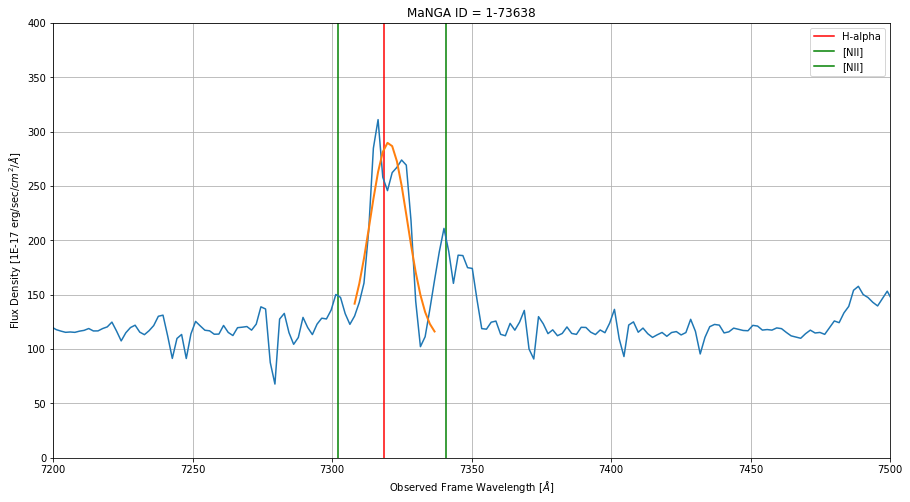

In [45]:
header = ['mangaid', 'plateifu', 'nsa_z', 'flux', 'FWHM km/s']
with open('problems.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    
    writer.writerow(header)
    
    for plateifu in problems:
        data = fits.open(f'/Volumes/WD_External/All_Objects/manga-{plateifu[0]}-LOGCUBE.fits.gz')
        mangaid = data[0].header['MANGAID']

        flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

        ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

        mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))

        do_not_use = (mask & 2**10) != 0 

        wave = data['WAVE'].data

        sumflux = spectrum_gen(flux, ivar)

        peak_ha = 6563 * (1 + plateifu[1])
        peak_6548 = 6548 * (1 + plateifu[1])
        peak_6583 = 6583 *(1 + plateifu[1])

        bound_ha = np.where(np.logical_and(wave > peak_ha-12, wave < peak_ha+20))
        
        idx_6548 = np.where(wave < peak_6548)
        idx_6583 = np.where(wave > peak_6583)
        
        base_6548 = sumflux[idx_6548[0][-50] : idx_6548[0][-1]+1]
        base_6583 = sumflux[idx_6583[0][0] : idx_6583[0][50]]
        base_total = np.mean(base_6548 + base_6583)
#         print(base_total)
        
#         print('6548', idx_6548[0], len(idx_6548[0]))
#         print('6583', idx_6583[0], len(idx_6583[0]))

        lb_ha = bound_ha[0][0]
        ub_ha = bound_ha[0][-1]

        sumflux_slice_ha = sumflux[lb_ha : ub_ha]

        wave_slice_ha = wave[lb_ha : ub_ha]
        print('wave_slice difference', wave_slice_ha[-1] - wave_slice_ha[0])

        amp_ha = max(sumflux_slice_ha)
        mean_ha = peak_ha
        sigma_ha = np.std(wave_slice_ha)
#         base_ha = np.mean(sumflux[idx_6548[0][-50] : idx_6548[0][-1]+1] 
#                                            + sumflux[idx_6583[0][0] : idx_6583[0][50]]) 
                  #min(sumflux_slice_ha)

        p0_ha = [amp_ha, mean_ha, sigma_ha, base_total]

        popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
        
        print('amp', popt_ha[0])
        print('mean', popt_ha[1])
        print('sigma', popt_ha[2])
        print('base', popt_ha[3])
        new_amp = popt_ha[0]+popt_ha[3]
        print('new_amp', new_amp)
        print()


#         area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (new_amp,
#                                                                            popt_ha[1],
#                                                                            sigma_ha,
#                                                                            base_total))
        
        area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (popt_ha[0],
                                                                           popt_ha[1],
                                                                           popt_ha[2],
                                                                           popt_ha[3]))
        
        print('Flux + continuum =', area[0])

        continuum = (wave_slice_ha[-1] - wave_slice_ha[0]) * popt_ha[3]
        
        print('Continuum', continuum)

        subtracted_area = area[0] - continuum

        print('Flux =', subtracted_area)
        
        fwhm_kms = popt_ha[2] * c / l_ha

        writer.writerow([mangaid, plateifu[0], plateifu[1], subtracted_area, fwhm_kms])
        
#         popt, pcov = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, 
#                                p0 = [amp_ha, mean_ha, sigma_ha, base_ha])

        plt.figure(figsize = (15,8))
        plt.grid()
        plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
        plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
        plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
        plt.legend()
        plt.xlim(7200, 7500)
        plt.ylim(0,400)
        plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
        plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
        plt.title(f'MaNGA ID = {mangaid}')

        plt.plot(wave, sumflux)

        plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)

        plt.show()